## This Notebook plots trajectory and speed of mice in the Barnes maze. Data from Célanie with Thomas (Marissasl)

## <span style="color:darkred"> 1. Load libraries 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import math
import matplotlib.cm as cm 
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

## <span style="color:darkred"> 2. Access the data locally (Notebook)

In [3]:
path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ExternCollab/CelanieData'
os.chdir(path_to_data_folder)
print('you are here: ' + os.getcwd())
print('and the files in your directory are:')  
excelFileNames=[]
for file in glob.glob('*.xlsx'):
        print(file)
        excelFileNames.append(file)

you are here: /Users/davidrobbe/Documents/Science/Data/ExternCollab/CelanieData
and the files in your directory are:
Raw_data-C7-4_D2S2_simpl.xlsx
Raw_data-C4-3_D3S2_simpl.xlsx
Raw_data-C8-1_D3S1_simpl.xlsx


In [48]:
# small loop to remplace space in file names by _ 
for file in glob.glob('*.xlsx'):
    new_name = file.replace(' ', '_')
    os.rename(file, new_name)
    print(f'Renamed: {file} → {new_name}')

Renamed: Raw_data-C7-4_D2S2_simpl.xlsx → Raw_data-C7-4_D2S2_simpl.xlsx
Renamed: Raw_data-C4-3_D3S2_simpl.xlsx → Raw_data-C4-3_D3S2_simpl.xlsx
Renamed: Raw_data-C8-1_D3S1_simpl.xlsx → Raw_data-C8-1_D3S1_simpl.xlsx


In [5]:
# get the full path of the excel file you want to process using an index of the list of excel files
full_path_excelfiletoprocess = os.path.join(path_to_data_folder, excelFileNames[2])
print(full_path_excelfiletoprocess)

/Users/davidrobbe/Documents/Science/Data/ExternCollab/CelanieData/Raw_data-C8-1_D3S1_simpl.xlsx


In [6]:
# Load the file and skip header lines
df = pd.read_excel(full_path_excelfiletoprocess, sheet_name='Track-Arena 1-Subject 1', skiprows=38, header=None)

# Rename relevant columns
df = df[[1, 2, 3]]  # Assuming columns: 0 = time, 2 = X, 3 = Y
df.columns = ['Recording Time', 'X Center', 'Y Center']

print(df.head())

   Recording Time  X Center  Y Center
0            0.04 -0.660618  0.450406
1            0.08 -0.655435  0.453862
2            0.12 -0.628315  0.441394
3            0.16 -0.628472  0.446608
4            0.20 -0.631778  0.437638


In [73]:
# Extract time and positions from the DataFrame
time_video_frames = df['Recording Time'].to_numpy()
xpositions = df['X Center'].to_numpy()
ypositions = df['Y Center'].to_numpy()

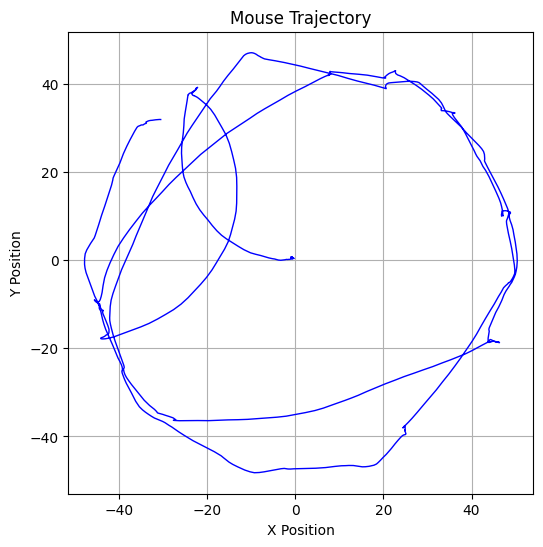

In [7]:
# Replace non-numeric entries with NaN and drop them
df_clean = df.copy()
df_clean['Recording Time'] = pd.to_numeric(df_clean['Recording Time'], errors='coerce')
df_clean['X Center'] = pd.to_numeric(df_clean['X Center'], errors='coerce')
df_clean['Y Center'] = pd.to_numeric(df_clean['Y Center'], errors='coerce')

# Drop rows with any NaN
df_clean = df_clean.dropna(subset=['Recording Time', 'X Center', 'Y Center'])

# Extract clean arrays
time_video_frames = df_clean['Recording Time'].to_numpy()
xpositions = df_clean['X Center'].to_numpy()
ypositions = df_clean['Y Center'].to_numpy()


# Plot
plt.figure(figsize=(6, 6))
plt.plot(xpositions, ypositions, color='blue', linewidth=1)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Mouse Trajectory')
plt.axis('equal')
plt.grid(True)
plt.show()

In [8]:
# Smoothing parameter
smooth_sigma = 2
# Smooth positions
smoothed_Xpositions = gaussian_filter1d(xpositions, sigma=smooth_sigma)
smoothed_Ypositions = gaussian_filter1d(ypositions, sigma=smooth_sigma)

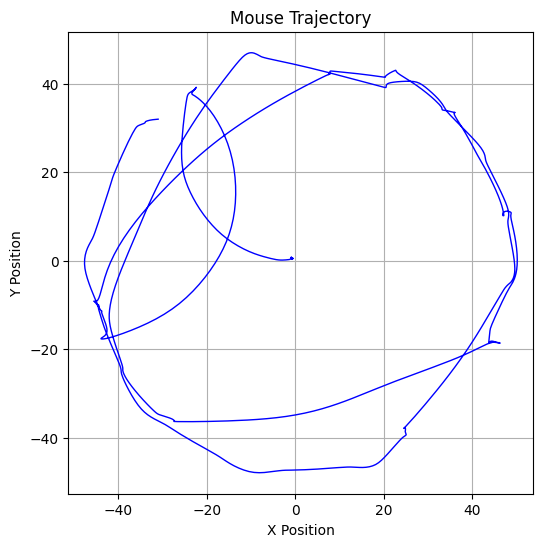

In [9]:
# Plot
plt.figure(figsize=(6, 6))
plt.plot(smoothed_Xpositions, smoothed_Ypositions, color='blue', linewidth=1)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Mouse Trajectory')
plt.axis('equal')
plt.grid(True)
plt.show()

In [11]:


# ### Function to compute distance, speed, and angular speed in degrees per second.
# #### We only compute angular speed when mice is moving above a certain speed threshold in cm/s

def compute_distance_speed_angular_speed(smoothed_positions, time_video_frames, speed_threshold=5):
    # Calculate the differences between consecutive points
    delta_x = np.diff(smoothed_positions[0])
    delta_y = np.diff(smoothed_positions[1])
    delta_t = np.diff(time_video_frames)

    # Compute the distances traveled between each timepoint
    distances = np.sqrt(delta_x**2 + delta_y**2)

    speeds = distances / delta_t
    smooth_sigma = 1 #the sigma used for the remaining of the analysis for smoothing
    speeds = gaussian_filter1d(speeds, sigma=smooth_sigma)

    # Compute the angles between each timepoint
    angles = np.arctan2(delta_y, delta_x)

    # Compute the differences between consecutive angles
    delta_angles = np.diff(angles)

    # Convert delta_angles from radians to degrees
    delta_angles_deg = np.degrees(delta_angles)

    # Ensure angles are within -180 to 180 range
    delta_angles_deg = (delta_angles_deg + 180) % 360 - 180

    # Mask speeds below the threshold
    valid_mask = speeds > speed_threshold

    # Compute angular speeds in degrees per second
    angular_speeds = np.zeros_like(delta_angles_deg)
    valid_delta_t = delta_t[1:][valid_mask[1:]]
    angular_speeds[valid_mask[1:]] = delta_angles_deg[valid_mask[1:]] / valid_delta_t

    # Filter angular speeds to include only those above the threshold
    filtered_angular_speeds = angular_speeds[valid_mask[1:]]

    # Get the times corresponding to filtered angular speeds
    # filtered_times = time_video_frames[1:][valid_mask[1:]]

    # Create a structured output with angular speeds and corresponding times
    # angular_speeds_with_times = list(zip(filtered_times, filtered_angular_speeds))

    distances= np.insert(distances, 0, 0) # insert a 0 to avoid length error with  time_video_frames. We consider that
                                        # at the first frame the distance is null
    speeds = np.insert(speeds, 0, 0) # insert a 0 to avoid length error with time_video_frames. We consider that
                                        # at the first frame the speed is null


    return distances, speeds, filtered_angular_speeds

In [12]:
# Combine smoothed positions in cm
smoothed_positions = [smoothed_Xpositions, smoothed_Ypositions]
distances, speeds, filtered_angular_speeds = compute_distance_speed_angular_speed(smoothed_positions, time_video_frames, speed_threshold=5)

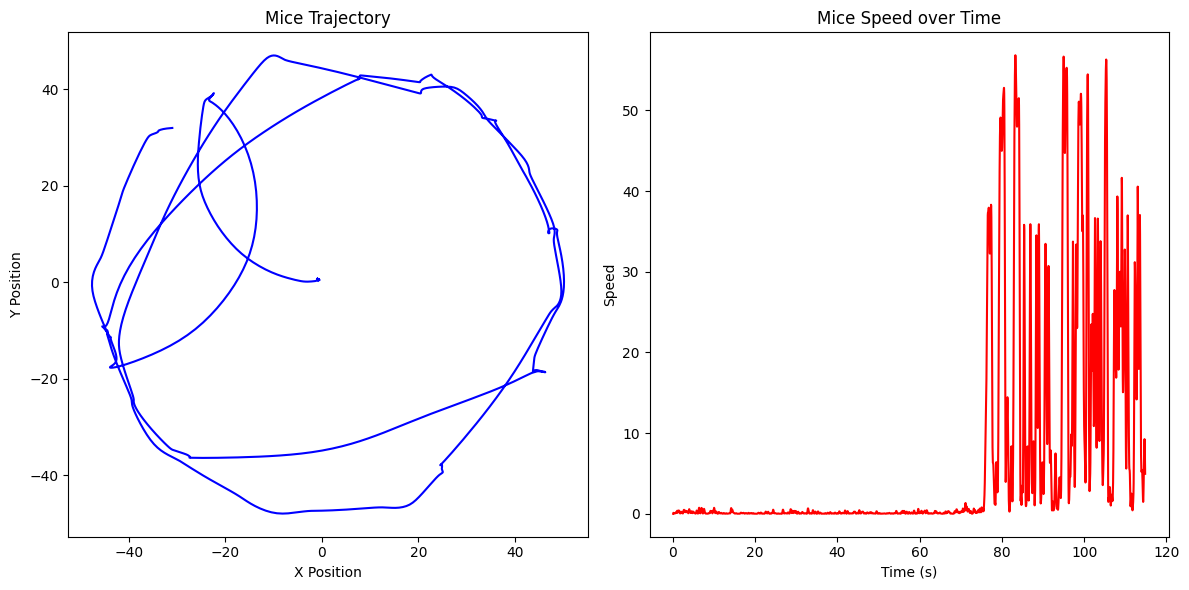

In [13]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot trajectory
ax[0].plot(smoothed_Xpositions, smoothed_Ypositions, color='b', label='Trajectory')
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')
ax[0].set_title('Mice Trajectory')
ax[0].axis('equal')  # Equal scaling on both axes

# Plot speed over time
ax[1].plot(time_video_frames, speeds, color='r', label='Speed')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Speed')
ax[1].set_title('Mice Speed over Time')

# Show the plot
plt.tight_layout()
plt.show()

In [80]:
def detect_run_epochs(speeds, time_video_frames):
    """
    
    Identifies continuous epochs during which the mouse is moving above a certain speed (cut_off_speed).
    A minimal duration of low speed is necessary to be considered as the end of a run.
    Similarly, a minimal duration of high speed is necessary to be considered as a run.
    """
    
    #for this we need some parameters to cut the trajectory into run based on speed, duration of runs and pauses
    pause_min_duration = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
    run_min_duration = 0.3 #minimal duration of an epoch to be considerd
    cut_off_speed = 7 # this value is the speed in cm/s. It is used to detect when the animals stop running. 
    
    
    
    run_epochs = []
    is_in_epoch = False  # Flag to track if we are currently in a running epoch
    epoch_start_index = 0

    if len(speeds) != len(time_video_frames):
        raise ValueError("speeds and time_video_frames have different lengths")

    for i in range(len(speeds)):
        if speeds[i] >= cut_off_speed:  # Speed above cut-off value
            if not is_in_epoch: # if the previous trajectory speed was not part of running epoch then this will be a start of a new epoch
                epoch_start_index = i  # Mark the beginning of a new epoch
                is_in_epoch = True
        else: # the speed of the current data point is below the treshold
            if is_in_epoch: # if we were in a run epoch just before (1st point below the treshold)
                # Check first if the pause between this epoch's starting point (time_video_frames[epoch_start_index]) and  
                # the previous epoch' last point time_video_frames[run_epochs[-1][1]] is shorter than the minimal time for a pause
                # then the previous epoch  should be extended to the previous data point.  
                if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
                    run_epochs[-1][1] = i - 1  # Extend the previous epoch
                else: # the pause has been long enough then we terminate the run epoch  other previous 
                    run_epochs.append([epoch_start_index, i - 1])  # Add new epoch
                is_in_epoch = False

    # Final check for any epoch still in progress
    if is_in_epoch:
        if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
            run_epochs[-1][1] = len(speeds) - 1
        elif (time_video_frames[-1] - time_video_frames[epoch_start_index]) >= run_min_duration:
            run_epochs.append([epoch_start_index, len(speeds) - 1])

    # Remove epochs that are too short
    run_epochs = [epoch for epoch in run_epochs if (time_video_frames[epoch[1]] - time_video_frames[epoch[0]]) >= run_min_duration]
    
    # Adjust the start and end of each epoch based on acceleration. The idea is that with the threshold method we miss the beginning and enf of the run
    # for the starting point. We are going back and find the point at wich the animal acceleration is less than 40% 
    # than the acceleration at the moment at which he passed the treshold. 
    clean_run_epochs = [None] * len(run_epochs)
    for index,epoch in enumerate(run_epochs):
        clean_run_epochs[index] = epoch.copy()
        epoch_start, epoch_end = epoch[0], epoch[1]
        # Adjust the start of the epoch
        current_point = epoch_start
        acceleration_at_crossing=(speeds[current_point + 1] - speeds[current_point]) / (time_video_frames[current_point + 1] - time_video_frames[current_point])
        while current_point > 0:
            previous_acceleration = (speeds[current_point] - speeds[current_point - 1]) / (time_video_frames[current_point] - time_video_frames[current_point - 1])
            if previous_acceleration <= (0.1 * acceleration_at_crossing) or previous_acceleration <= 0:
                break
            current_point -= 1
            #print(f'it went backward on epoch {index}')
        clean_run_epochs[index][0] = current_point

    #Adjust the end of the epoch
    #We are going forward after the speed crossed downward the speed threshold and find the point at wich the animal acceleration is less than 40% 
    #than the acceleration at the moment at which it passed the treshold. 
        current_point = epoch_end
        acceleration_at_crossing=(speeds[current_point - 1] - speeds[current_point]) / (time_video_frames[current_point] - time_video_frames[current_point-1])
        while current_point < len(speeds) - 1:
            next_acceleration = (speeds[current_point] - speeds[current_point + 1]) / (time_video_frames[current_point+1] - time_video_frames[current_point])
            if next_acceleration <= (0.1 * acceleration_at_crossing) or next_acceleration <= 0:
                break
            current_point += 1
            #print(f'it went forward on epoch {index}')
        clean_run_epochs[index][1] = current_point

    
   
    return clean_run_epochs,run_epochs 

In [81]:
clean_run_epochs,run_epochs=detect_run_epochs(speeds,time_video_frames)

In [82]:
for run_epoch in clean_run_epochs:
    print(run_epoch)

[49, 76]
[76, 96]
[96, 117]
[118, 146]
[150, 172]
[172, 190]
[191, 209]
[215, 245]
[246, 276]
[307, 329]
[344, 363]
[366, 399]
[443, 480]
[480, 514]
[528, 550]
[637, 662]
[672, 687]
[735, 773]
[773, 796]
[796, 852]
[853, 871]
[871, 893]
[900, 921]
[921, 948]
[972, 998]
[1014, 1044]
[1058, 1088]
[1121, 1224]
[1224, 1251]
[1322, 1361]
[1362, 1402]
[1475, 1514]
[1541, 1608]
[1685, 1709]
[1760, 1782]
[1830, 1865]
[1872, 1903]
[1904, 1929]
[1930, 1962]
[1972, 2002]
[2012, 2044]
[2104, 2129]
[2213, 2247]
[2337, 2365]
[2447, 2479]


In [83]:
def plot_trajectory_speed_chunk(start_idx, end_idx, traject_time, speeds, run_epochs, clean_run_epochs,  
                                  smoothed_Xpositions, smoothed_Ypositions, cut_off_speed=7,events_list=None):
    """
    Plots a chunk of speeds from start_idx to end_idx, visualizes the run_epochs and clean_run_epochs,
    and plots the trajectory of the mice during the same chunk.
    
    Parameters:
        start_idx (int): Start index of the chunk to plot.
        end_idx (int): End index of the chunk to plot.
        traject_time (np.array or list): List or array of time points corresponding to trajectory speeds.
        speeds (list): List of trajectory speeds.
        run_epochs (list): List of original run epochs, each epoch is a tuple (start_index, end_index).
        clean_run_epochs (list): List of adjusted run epochs, each epoch is a tuple (start_index, end_index).
        cut_off_speed (float): The speed threshold for determining run epochs.
        smoothed_Xpositions (list): List of smoothed X positions of the mice in cm.
        smoothed_Ypositions (list): List of smoothed Y positions of the mice in cm.
        events_list (list, optional): List of event times to plot as vertical lines.
    """
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 16))
    
    # First subplot: Mice Trajectory

    # Plot trajectory with different symbols for first and last points
    axs[0].plot(smoothed_Xpositions[start_idx:end_idx], smoothed_Ypositions[start_idx:end_idx], color='black', linestyle='-', marker='o', markerfacecolor='none')
    axs[0].scatter(smoothed_Xpositions[start_idx], smoothed_Ypositions[start_idx], color='green', marker='o', edgecolor='green', label='Start Point',s=100)
    axs[0].scatter(smoothed_Xpositions[end_idx - 1], smoothed_Ypositions[end_idx - 1], color='red', marker='o', edgecolor='red', label='End Point',s=100)
    
    axs[0].set_aspect('equal')
    axs[0].set_xlabel('X Position (cm)')
    axs[0].set_ylabel('Y Position (cm)')
    axs[0].set_title('Mice Trajectory during the Selected Chunk')
    
    
    
    
    
    
    # Second subplot: Trajectory Speeds
    axs[1].plot(traject_time[start_idx:end_idx], speeds[start_idx:end_idx], label='Trajectory Speeds', color='black', marker='o', markerfacecolor='none')
    
    # Mark the first and last points with different symbols and colors
    axs[1].scatter(traject_time[start_idx], speeds[start_idx], color='green', marker='o', s=100, label='Start Point')
    axs[1].scatter(traject_time[end_idx - 1], speeds[end_idx - 1], color='red', marker='o',s=100, label='End Point')
    
    axs[1].axhline(y=cut_off_speed, color='orange', linestyle='--', label='Cut-off Speed')
    
    # Plot original run epochs on the first subplot
    for idx, epoch in enumerate(run_epochs):
        epoch_start, epoch_end = epoch[0], epoch[1]
        if epoch_start >= start_idx and epoch_end <= end_idx:
            axs[1].axvspan(traject_time[epoch_start], traject_time[epoch_end], color='red', alpha=0.3, label='Original Run Epoch' if idx == 0 else "")
    
    # Plot adjusted run epochs on the first subplot
    for idx, epoch in enumerate(clean_run_epochs):
        epoch_start, epoch_end = epoch[0], epoch[1]
        if epoch_start >= start_idx and epoch_end <= end_idx:
            axs[1].axvspan(traject_time[epoch_start], traject_time[epoch_end], color='green', alpha=0.3, label='Adjusted Run Epoch' if idx == 0 else "")
    
    # Plot optional events on the first subplot
    if events_list is not None:
        for event in events_list:
            event_index = np.where(traject_time == event)[0]
            if event_index.size > 0:  # Check if the event exists in the time array
                axs[1].axvline(x=traject_time[event_index[0]], color='magenta', linestyle='--', label='Event')
    
    axs[1].set_ylim(bottom=-5, top=70)
    axs[1].set_xlabel('Time (Seconds)')
    axs[1].set_ylabel('Speed (cm/s)')
    axs[1].set_title('Trajectory Speeds with Run Epochs Highlighted')
    axs[1].legend()
    
    
    plt.tight_layout()
    plt.show()


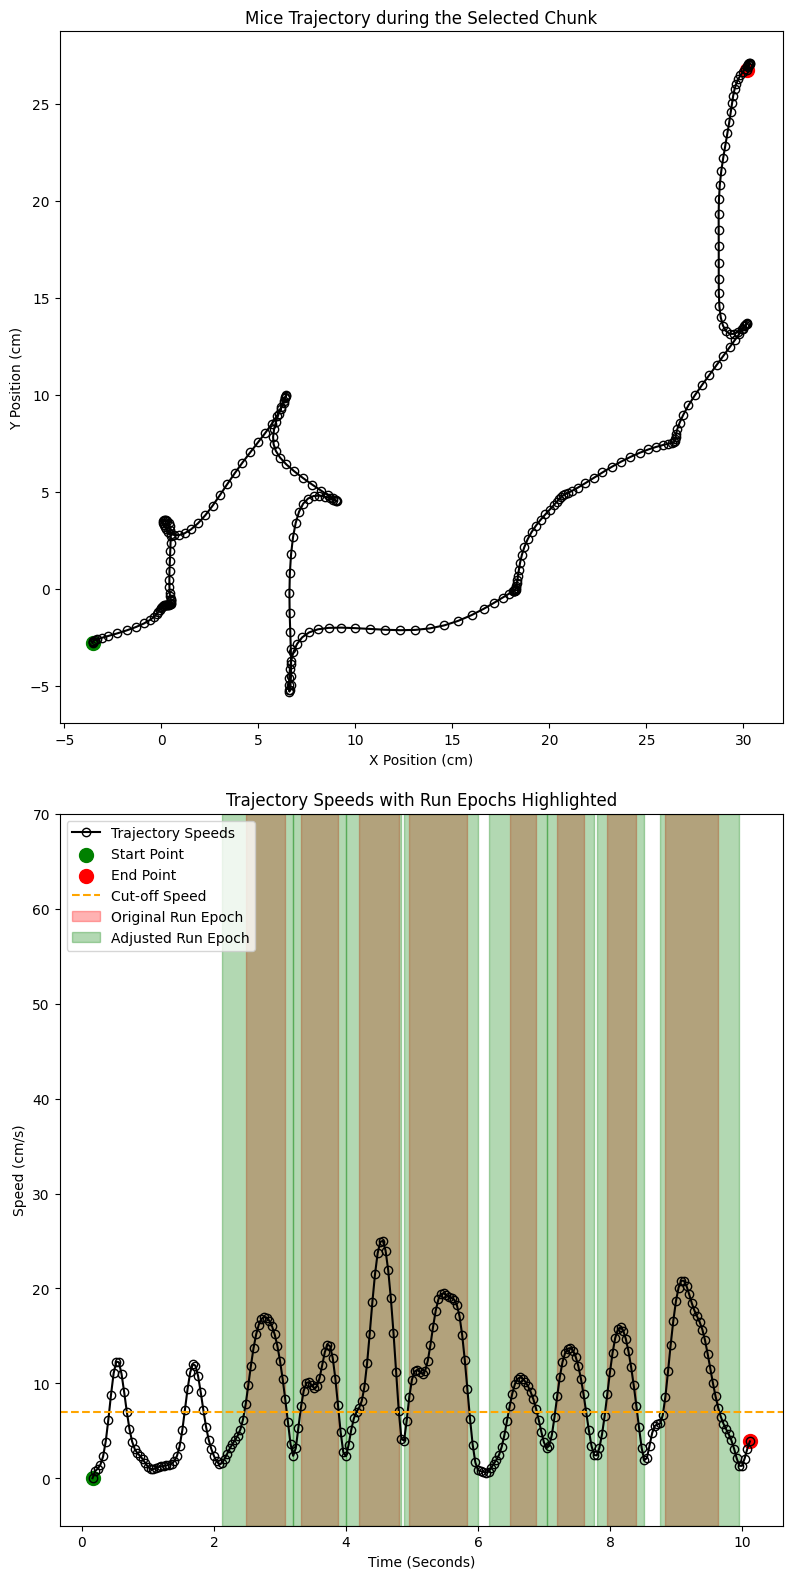

In [87]:
plot_trajectory_speed_chunk(0*25, 10*25, time_video_frames,speeds, run_epochs, clean_run_epochs, smoothed_Xpositions, smoothed_Ypositions)


In [88]:
# Identify immobility epochs
immobility_epochs = []
for i in range(len(clean_run_epochs) - 1):
    current_epoch_end = clean_run_epochs[i][1]
    next_epoch_start = clean_run_epochs[i + 1][0]
    
    if current_epoch_end < next_epoch_start:
        immobility_epochs.append([current_epoch_end, next_epoch_start])

for immobility_epoch in immobility_epochs:
    print(immobility_epoch)

[117, 118]
[146, 150]
[190, 191]
[209, 215]
[245, 246]
[276, 307]
[329, 344]
[363, 366]
[399, 443]
[514, 528]
[550, 637]
[662, 672]
[687, 735]
[852, 853]
[893, 900]
[948, 972]
[998, 1014]
[1044, 1058]
[1088, 1121]
[1251, 1322]
[1361, 1362]
[1402, 1475]
[1514, 1541]
[1608, 1685]
[1709, 1760]
[1782, 1830]
[1865, 1872]
[1903, 1904]
[1929, 1930]
[1962, 1972]
[2002, 2012]
[2044, 2104]
[2129, 2213]
[2247, 2337]
[2365, 2447]


In [89]:
for clean_run_epoch in clean_run_epochs:
    print(clean_run_epoch)

[49, 76]
[76, 96]
[96, 117]
[118, 146]
[150, 172]
[172, 190]
[191, 209]
[215, 245]
[246, 276]
[307, 329]
[344, 363]
[366, 399]
[443, 480]
[480, 514]
[528, 550]
[637, 662]
[672, 687]
[735, 773]
[773, 796]
[796, 852]
[853, 871]
[871, 893]
[900, 921]
[921, 948]
[972, 998]
[1014, 1044]
[1058, 1088]
[1121, 1224]
[1224, 1251]
[1322, 1361]
[1362, 1402]
[1475, 1514]
[1541, 1608]
[1685, 1709]
[1760, 1782]
[1830, 1865]
[1872, 1903]
[1904, 1929]
[1930, 1962]
[1972, 2002]
[2012, 2044]
[2104, 2129]
[2213, 2247]
[2337, 2365]
[2447, 2479]


In [90]:
def detect_immobility_epochs(clean_run_epochs, time_video_frames):
    """
    Identify immobility periods based on the complement of clean_run_epochs.
    Handles immobility at the beginning and end of the trial.
    """
    immobility_epochs = []

    # Handle immobility before the first run
    if clean_run_epochs[0][0] > 0:
        immobility_epochs.append([0, clean_run_epochs[0][0] - 1])

    # Immobility between runs
    for i in range(len(clean_run_epochs) - 1):
        current_epoch_end = clean_run_epochs[i][1]
        next_epoch_start = clean_run_epochs[i + 1][0]
        if current_epoch_end + 1 < next_epoch_start:
            immobility_epochs.append([current_epoch_end + 1, next_epoch_start - 1])

    # Handle immobility after the last run
    if clean_run_epochs[-1][1] < len(time_video_frames) - 1:
        immobility_epochs.append([clean_run_epochs[-1][1] + 1, len(time_video_frames) - 1])

    return immobility_epochs


In [91]:
immobility_epochs = detect_immobility_epochs(clean_run_epochs, time_video_frames)

In [92]:
for immobility_epoch in immobility_epochs:
    print(immobility_epoch)

[0, 48]
[147, 149]
[210, 214]
[277, 306]
[330, 343]
[364, 365]
[400, 442]
[515, 527]
[551, 636]
[663, 671]
[688, 734]
[894, 899]
[949, 971]
[999, 1013]
[1045, 1057]
[1089, 1120]
[1252, 1321]
[1403, 1474]
[1515, 1540]
[1609, 1684]
[1710, 1759]
[1783, 1829]
[1866, 1871]
[1963, 1971]
[2003, 2011]
[2045, 2103]
[2130, 2212]
[2248, 2336]
[2366, 2446]
[2480, 2621]
